In [1]:
%pip install --user matplotlib
%pip install --user segmentation_models_pytorch

import torch
import numpy as np

from matplotlib import pyplot as plt
from segmentation_models_pytorch import Unet, Linknet, FPN, PSPNet
from torchvision.transforms import functional as tf
from PIL import Image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
def preprocess(image):
    if image.shape[0] in [1, 3]:
        image = image[0]
    elif image.shape[-1] in [1, 3]:
        image = image[..., -1]
    image = tf.to_pil_image(image)
    image = tf.resize(image, [512, 512])
    image = tf.to_tensor(image)
    image = tf.normalize(image, image.mean(), image.std())
    return image.unsqueeze(0)

def predict(image, experiment_name, architecture_name, encoder, encoder_weights):
    if architecture_name == 'Unet':
        architecture = Unet
    if architecture_name == 'Linknet':
        architecture = Linknet
    if architecture_name == 'FPN':
        architecture = FPN
    if architecture_name == 'PSPNet':
        architecture = PSPNet
    model = architecture(encoder, encoder_weights=encoder_weights, activation='sigmoid', in_channels=1).to('cpu')
    checkpoint = f'https://github.com/pbizopoulos/comprehensive-comparison-of-deep-learning-models-for-lung-and-covid-19-lesion-segmentation-in-ct/releases/latest/download/{experiment_name}-{architecture_name}-{encoder}-{encoder_weights}.pt'
    model.load_state_dict(torch.hub.load_state_dict_from_url(checkpoint, map_location='cpu'))
    model.eval()
    image = preprocess(image)
    prediction = model(image)
    prediction = prediction[0, 0].detach().numpy()
    prediction = prediction > 0.5
    return prediction

In [3]:
image = Image.open('./covid-19-pneumonia-4.jpg')
image = np.asarray(image)
experiment_name = 'lesion-segmentation-a' # or 'lung-segmentation'
architecture_name = 'PSPNet' # or any of 'Unet', 'Linknet', 'FPN'
encoder = 'mobilenet_v2' # or any of 'vgg11', 'vgg13', 'vgg19', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'resnext50_32x4d', 'dpn68', 'dpn98', 'mobilenet_v2', 'xception', 'inceptionv4', 'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3', 'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6'
encoder_weights = 'imagenet' # or 'None'
prediction = predict(image, experiment_name, architecture_name, encoder, encoder_weights)

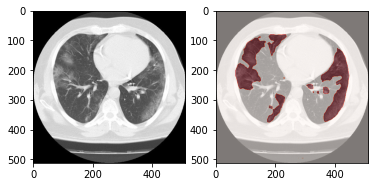

In [4]:
%matplotlib inline
plt.subplot(121)
plt.imshow(image, cmap='gray', vmin=-1.5, vmax=1.5)
plt.subplot(122)
plt.imshow(image, cmap='gray', vmin=-1.5, vmax=1.5)
plt.imshow(prediction, cmap='Reds', alpha=0.5)